# Sketchpad

Various experiments with ideology graphs.

In [9]:
# imports and includes
using LightGraphs, MetaGraphs, SNAPDatasets, Random, GraphPlot, Compose, Plots
include("../src/models.jl")   # Graph models
include("../src/dynamics.jl") # Dynamical systems
include("../src/dataviz.jl")  # Plotting for our graphs

drawcolorgraph (generic function with 1 method)

## Simple ideology graphs

Here we do the simple experiments. No quality attribute, 1- and 2-D ideology attributes, various graph generation models. No "media accounts."

### Erdos-Renyi models with a few different parameters. Small models.


In [ ]:
model = ermodel(20, 0.3, IGraph)
assignid!(model)
colornet!(model)
drawcolorgraph(model)

In [ ]:
model2 = copy(model)
drawcolorgraph(model)

### Erdos-Renyi model with media accounts added

In [ ]:
#model = ermodel(30, 0.2, IGraph)
#assignid!(model)
#addmedia_rand!(model, 2, 6, 0.5)
#colornet!(model)
#drawcolorgraph(model)
R = Array{Float64,1}(undef, 100)
for i = 1:100
    model = ermodel(30, 0.2, IGraph)
    assignid!(model)
    addmedia_rand!(model, 2, 6, 0.5)
    R[i] = R_M(model, 0.5, 0.5) / R_0(model, 0.5, 0.5)
end
sum(R) / 100

In [ ]:
model = wsmodel(50, 4, 0.3, IGraph)
assignid!(model)
addmedia_nearest!(model, 2, 5, [-0.9, 0.9])
colornet!(model)
drawcolorgraph(model)

## Timing benchmarks

In [ ]:
@time model = ermodel(1000, 0.025, IGraph)

In [ ]:
@time assignid!(model)

In [ ]:
@time addmedia_rand!(model, 10, 20, 0.6)

In [ ]:
@time updateg2!(model, 0.5)

In [ ]:
function updateg2!(g::IGraph, c)
    newids = Array{Float64, 1}()

    # for v in vertices(g.g) append!(newids, id_update(g, v, c)) end
    newids = [id_update(g,v,c) for v in vertices(g.g)]
    m = maximum([newids[v] - props(g.g, v)[:ideology] for v in vertices(g.g)])
    for v in vertices(g.g)
        if !has_prop(g.g, v, :media)
            set_prop!(g.g, v, :ideology, newids[v])
        end
    end
    (newids, m)
end

In [ ]:
@time id_update(model, 1, 0.5)

In [ ]:
function id_update2(g::IGraph, v, c, selfweight = 1)
    selfid = props(g.g, v)[:ideology]
    newid = selfid * selfweight
    n = 0
    for w in neighbors(g.g, v)
        i = props(g.g, w)[:ideology]
        if g.distance(i, selfid) <= c
            newid += i
            n += 1
        end
    end
    newid / (n + selfweight)
end

In [ ]:
@time id_update2(model, 1, 0.5)

In [ ]:
@time fullsim!(model, 0.5)

In [ ]:
[props(model.g, i)[:ideology] for i = 1:nv(model.g)]

In [ ]:
function fullsim_blank!(g::IGraph, c, tol = 10^(-4), maxsteps = 1000)
    m = 1
    #ids = [props(g.g, v)[:ideology] for v in vertices(g.g)]
    steps = 0
    while m > tol && steps < maxsteps
        m = updateg!(g, c)[2]
    end
    return true
end

In [ ]:
model = ermodel(250, 0.3, IGraph)
assignid!(model)
addmedia_rand!(model, 10, 20, 0.6)
@time modelb = copy(model)

In [ ]:
@time fullsim_blank!(model, 0.5)

In [ ]:
@time fullsim!(modelb, 0.5)

### Graph from the Facebook100 data set

In [ ]:
reed = fbgraph("Reed98", IGraph)
harvard = fbgraph("Harvard1", IGraph)

In [ ]:
@time assignid!(reed)
addmedia_rand!(reed, 11, 225, 0.9)
@time assignid!(harvard)
addmedia_rand!(harvard, 30, 300, 0.9)
#colornet!(reed)
#drawcolorgraph(reed)

In [ ]:
n(harvard.g)

In [ ]:
@time reed_ids = fullsim!(reed, 0.5)
@time harvard_ids = fullsim!(harvard, 0.5)

In [ ]:
plot(1:size(reed_ids)[2],transpose(reed_ids))

## Simple dynamical experiments

In a simple ER model all but the most extreme accounts homogenize to a fairly neutral ideology. In sufficiently connected graphs, or with a large enough acceptance parameter, all accounts will generally homogenize.

In [ ]:
model = ermodel(20, 0.3, IGraph)
assignid!(model)
ids = fullsim!(model, 0.5)


In [ ]:
ids

In [ ]:
plot(1:size(ids)[2],transpose(ids))

In [ ]:
colornet!(model)
drawcolorgraph(model)

In [ ]:
model = ermodel(60, 0.1, IGraph)
assignid!(model)
ids, steps = fullsim!(model, 0.9)
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, :], xlims=(1, size(ids)[2]))
end

In [ ]:
colornet!(model)
drawcolorgraph(model)

In the presence of a media account, many accounts will become "entrained" to the media account. A handful of accounts may retain different ideology.

In [ ]:
model = ermodel(120, 0.1, IGraph)
assignid!(model)
addmedia_nearest!(model, 1, 12, [0.8])
addmedia_nearest!(model, 1, 12, [-0.8])
ids = fullsim!(model, 0.5)
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, :], xlims=(1, size(ids)[2]), legend = nothing)
end

In [ ]:
model = ermodel(20, 0.3, IGraph)
assignid!(model)
#addmedia_rand!(model, 1, 12, 0.8)
#addmedia_rand!(model, 1, 12, -0.8)
ids = fullsim!(model, 0.5)
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, :], xlims=(1, size(ids)[2]), legend = nothing)
end

In [ ]:
model = wsmodel(100, 8, 0.5, IGraph)
assignid!(model)
addmedia_nearest!(model, 1, 12, [0.8])
addmedia_nearest!(model, 1, 12, [-0.8])
ids, steps = fullsim!(model, 0.5, 10^(-4), 1000)
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, :], xlims=(1, size(ids)[2]))
end

In [ ]:
model = wsmodel(100, 8, 0.5, IGraph)
assignid!(model)
addmedia_rand!(model, 2, 12, 0.6)
addmedia_rand!(model, 2, 12, -0.6)
ids, steps = fullsim!(model, 0.5, 10^(-4), 1000)
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, :], xlims=(1, size(ids)[2]))
end

In [ ]:
model = SNAPIdeog(:ego_twitter_u, IGraph)
assignid!(model)
addmedia_nearest!(model, 10, 1000, [0.3, 0.3, 0.3, 0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7])
addmedia_nearest!(model, 10, 1000, [-0.3, -0.3, -0.3, -0.5, -0.5, -0.5, -0.5, -0.7, -0.7, -0.7])

In [ ]:
ids, steps = fullsim!(model, 0.5, 10^(-4), 300)

In [ ]:
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, :], xlims=(1, size(ids)[2]))
end

In [ ]:
verts = random_verts(model.g, 500)
@gif for i=1:size(ids)[2]
    plot(1:i,transpose(ids)[1:i, verts], xlims=(1, size(ids)[2]), legend = nothing)
end

### Examples with quality

In [10]:
model = ermodel(50, 0.25, IQGraph)
assignid!(model)
assignq!(model)
addmedia_rand!(model, 2, 20, 0.7, 0.9)

true

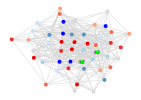

In [11]:
colornet!(model)
drawcolorgraph(model)

In [12]:
ids, quals = fullsim!(model, 0.5)

([-0.48 -0.528 … -0.5071349524227697 -0.5071349524227697; -0.04 -0.09333333333333334 … -0.5071349524227697 -0.5071349524227697; … ; 0.7 0.0 … 0.0 0.0; 0.7 0.0 … 0.0 0.0], [0.6525124225976902 0.603930225810746 … 0.5701212564580396 0.5701212564580396; 0.38347813814678555 0.5008216287205531 … 0.5701212564580396 0.5701212564580396; … ; 0.9 0.0 … 0.0 0.0; 0.9 0.0 … 0.0 0.0])

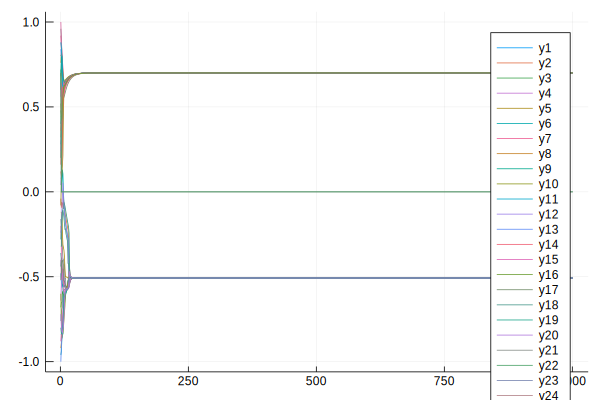

In [13]:
plot(1:size(ids)[2],transpose(ids))

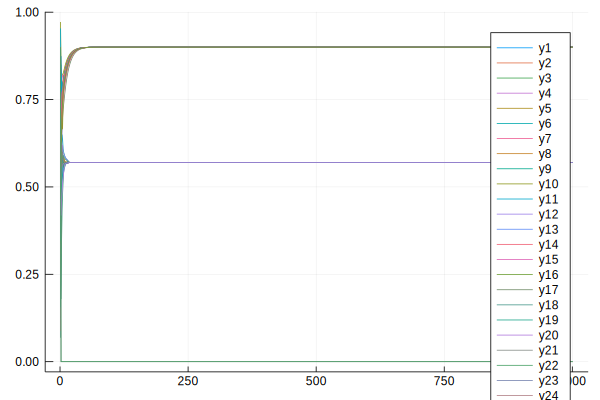

In [14]:
plot(1:size(quals)[2],transpose(quals))